In [57]:
import os
import json

from Bio.SeqIO import QualityIO
import numpy as np
# import re
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
from functions_ import *
from plotting import *
from Bio import SeqIO
from Bio.Seq import Seq
from characterization_from_blast_alignments import *
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar  # Import colorbar module

In [66]:

import matplotlib
custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 6
hi = 6.69291
wi = 7.08661
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 


In [4]:
amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
end_LOV2 = "cggccaaa".upper() ## LOV2 end



ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


In [9]:
### get enrichment 
Folder = "/home/student/anna/DMS_analysis/output/RL8/blast/R1/enrichments/Codons/" 
enrichment = pd.read_csv(f"{Folder}/RL8_BC1_S1_R1_roiTrue_Codons_enrichment_relative.csv", index_col = 0)
mut_spectrum_codons_perc = pd.read_csv(f"{Folder}/RL8_BC1_S1_R1_roiTrue_Codons_mut_spec.csv", index_col = 0)

In [49]:

## filtering of mutagenic spectrum for plotting 
ref_len = len(enrichment.columns) * 3 ## Nts instead of codons
ref_len = ref_len + amplicon_AraCLOV2.index(start_LOV2) ## include start of LOV2

ref_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0,ref_len, 3)]

pref_codons = sorted(ecoli_pref.values())



## order the mutagenic spectrum according to the pref codons and filter for the reference codons
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc.loc[:,pref_codons], mut_spectrum_codons_perc.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:]
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0)

## find codons that are included in (non-targeted) AraC but not in (targeted) LOV sequence
## find start position of LOV2 in seq
LOVstart = amplicon_AraCLOV2.index(start_LOV2)
AraC_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0, LOVstart, 3)] # AraC codons
LOV_codons = [amplicon_AraCLOV2[i:i+3] for i in range(LOVstart, ref_len, 3)] # LOV codons
## filter codons that are only in AraC but not LOV2 seq
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

## count occs 
counter_LOV = Counter(LOV_codons)
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key
        
counter_LOV = dict(sorted(counter_LOV.items()))
### annotations: 
col_annot = ["grey" if codon in pref_codons else "lightgrey" for codon in mut_spec_perc_ordered.columns]
row_annot_vals = list(counter_LOV.values())
# convert row_annot to colors of cmap


cmap = plt.get_cmap('Oranges')
norm = plt.Normalize(min(row_annot_vals), max(row_annot_vals))
row_annot = [cmap(norm(value)) for value in row_annot_vals]

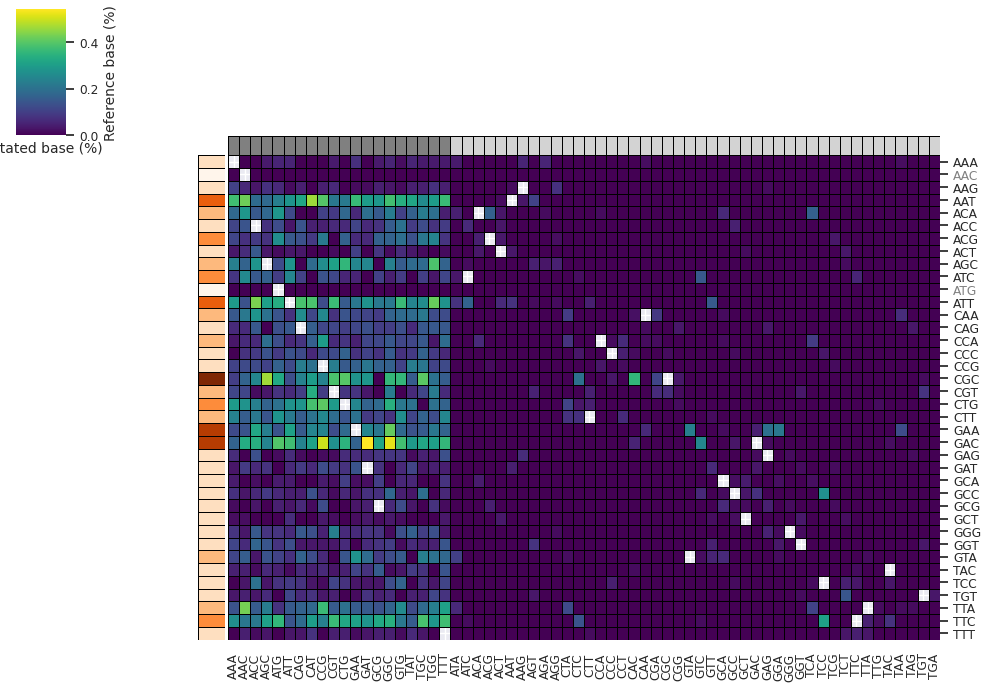

In [51]:
######### not normalized but rows annotated 
sns.set(font_scale=0.8)
g = sns.clustermap(mut_spec_perc_ordered, annot=False, linewidths=.5,  figsize = (10,7), linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True,col_cluster = False, row_cluster = False,  row_colors=row_annot, col_colors=col_annot, yticklabels = True)

plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
for i, tick_label in enumerate(g.ax_heatmap.axes.get_yticklabels()):
    if tick_label.get_text() not in LOV_codons:
        tick_label.set_color('grey')

# plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")

plt.show()

## AA level

In [90]:
variant = "RL8"
### get enrichment 
Folder = f"/home/student/anna/DMS_analysis/final_output/{variant}/combined/" 
mut_spectrum_AA_perc = pd.read_csv(f"{Folder}/enrichments/AA/{variant}_BC1_S1_combined_roiTrue_AA_mut_spec.csv", index_col = 0)
FigFolder = Folder+ "/plots/AA/"

In [91]:
LOV2_AAs = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

In [92]:

## count occs
counter_LOV = Counter(LOV2_AAs)
for codon in mut_spectrum_AA_perc.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key but with "*" at the end
counter_LOV = dict(sorted(counter_LOV.items(), key = lambda x: x[0] if x[0] != "*" else "Z"))
### annotations: 

row_annot_vals = list(counter_LOV.values())
# convert row_annot to colors of cmap


annot_cmap = plt.get_cmap('Greys').reversed()
norm = plt.Normalize(min(row_annot_vals), max(row_annot_vals))
row_annot = [cmap(norm(value)) for value in row_annot_vals]

colors = ["#22577A", "#C7F9CC"] # Light green to light blue

cmap =  LinearSegmentedColormap.from_list("custom_cmap", colors , N=256)

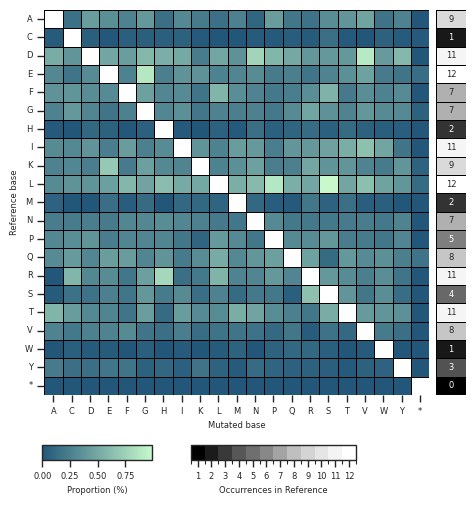

In [93]:
######### not normalized but rows annotated 
fig, axes = plt.subplots(1, 2, figsize=(5.5, 5), gridspec_kw={"width_ratios": [4, 0.3]})
fig.subplots_adjust(wspace=0.01)

sns.heatmap(mut_spectrum_AA_perc, annot=False, linecolor = "black", cmap = cmap,  xticklabels=True,yticklabels = True, ax=axes[0], cbar = False, linewidths=.5, square=True)

sns.heatmap(pd.DataFrame(row_annot_vals), cmap=annot_cmap, annot=True, linewidths=.5,linecolor="black" ,
            xticklabels=False, yticklabels=True, ax=axes[1], cbar=False)

# Adjust layout
axes[1].set_yticks([])  # Remove yticks from annotation column
axes[1].set_ylabel("") 


axes[0].set_xlabel('Mutated base')
axes[0].set_ylabel('Reference base')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation = 0)

# plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")

cbar_ax = fig.add_axes([0.13, -0.02, 0.2, 0.03])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("Proportion (%)")

cbar_ax2 = fig.add_axes([0.4, -0.02, 0.3, 0.03])  # Position the second colorbar
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot_vals)+1.5, 1), ncolors=annot_cmap.N)

cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap=annot_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(row_annot_vals)+1,1))

cbar2.set_label("Occurrences in Reference")

plt.savefig(f"{FigFolder}/AAs_mutagenic_spectrum_roi_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.show()

In [ ]:
## calculate number of single/double/triple Nt changes codon-wise
Codon_vars = Codons_relative.loc[:,amplicon_AA.index("LATTLER"):]#seq_variants["Codons"].loc[:,amplicon_AA.index("LATTLER"):]

ref_codons = [LOV_gene[i:i+3] for i in range(0, Codon_vars.shape[1]*3, 3)]#[amplicon_DNA[i:i+3] for i in range(0, Codon_vars.shape[1]*3, 3)]

Nt_changes = {1:0, 2:0, 3:0} # single,double,triple Nt mutations within codons
position = 0
for pos, mut_Codons in Codon_vars.items(): # iterate columnwise over DF with counts of mutated Codons
    ref_codon = ref_codons[position]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)]) # count number of nt changes within the codon
            Nt_changes[n_changes] += mut_Codons[mut_codon] # add the proportion or count (depending on chosen df for Codon_vars) of the mutated codon to the respective category
    position += 1
relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}
        

In [ ]:
relative_Nt_changes_observed

In [ ]:
## calculate expected number of single/double/triple Nt changes codon-wise
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_Codon in ref_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_Codon: 
            n_changes = sum([ref_Codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

In [ ]:
plt.rcdefaults()
sns.barplot(relative_Nt_changes_observed, alpha = 0.7, label = "observed")
sns.barplot(relative_expected_Nt_changes, alpha = 0.5, label = "expected")
plt.legend(frameon = False)
plt.xlabel("Number of base changes within codons")
plt.ylabel("Relative frequency")
plt.title("RL8_AraC-LOV2_R1")
plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()